# 실제 양자컴퓨터 사용하기

## 학습 목표
- ✅ Qiskit Aer 시뮬레이터 완벽 활용
- ✅ IBM Quantum 실제 하드웨어 접속
- ✅ 노이즈 모델 이해와 적용
- ✅ 오류 완화 기법 실습

## Part 1: 환경 설정

In [ ]:
# 필수 라이브러리 설치 확인
import sys

def check_installation():
    """설치 상태 확인하는 함수"""
    libraries = {
        'qiskit': '양자 회로 작성',
        'qiskit_aer': '시뮬레이터',
        'qiskit_ibm_runtime': 'IBM 양자컴퓨터 연결',
        'matplotlib': '그래프 그리기',
        'numpy': '수학 계산'
    }
    
    print("📦 라이브러리 설치 확인")
    print("="*50)
    
    for lib, desc in libraries.items():
        try:
            __import__(lib.replace('_', '-') if '-' in lib else lib)
            print(f"✅ {lib:20} : {desc}")
        except ImportError:
            print(f"❌ {lib:20} : 설치 필요!")
            print(f"   설치 명령: pip install {lib.replace('_', '-')}")

check_installation()

In [19]:
# 라이브러리 임포트
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram, plot_circuit_layout
import numpy as np
import matplotlib.pyplot as plt
from qiskit import __version__

print("✅ 모든 라이브러리 로딩 완료!")
print(f"Qiskit 버전: {__version__}")

✅ 모든 라이브러리 로딩 완료!
Qiskit 버전: 2.1.2


## Part 2: 기본 양자 회로 시뮬레이션 (Bell state)

In [ ]:
# Bell State 생성
qc = QuantumCircuit(2)

qc.h(0)      # 첫 번째 큐비트를 중첩 상태로
qc.cx(0, 1)  # 두 큐비트를 얽힘 상태로

# # 측정
# qc.measure_all()

qc.draw('mpl')

In [ ]:
from qiskit.quantum_info import Statevector

Statevector(qc)

In [ ]:
from qiskit.visualization.array import array_to_latex

array_to_latex(Statevector(qc))

In [ ]:
qc.measure_all()

qc.draw('mpl')

### 2.1 백엔드 사용

In [ ]:
from qiskit.providers.fake_provider import GenericBackendV2

backend = GenericBackendV2(num_qubits=5, noise_info=True)

job = backend.run(qc)

counts = job.result().get_counts()

print(counts)

### 2.2 Sampler

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend)

job = sampler.run([qc])

counts = job.result().get_counts()

print(counts)

### 2.2-1 Transpile

양자 회로를 작성할 때 썼던 게이트들을 백엔드(QPU)에서 사용 가능한 양자 게이트 종류로 변경해야 사용할 수 있습니다.

In [ ]:
from qiskit import transpile

transpiled_qc = transpile(qc, backend)

job = sampler.run([transpiled_qc])

# counts = job.result()[0].data.meas.get_counts()
counts = job.result()[0].join_data().get_counts()

print(counts)

### 2.3 Aer Simulator

In [ ]:
from qiskit_aer import AerSimulator

| 메소드               | 설명                                                                                   | 특징 / 용도                                  |
|-----------------------|----------------------------------------------------------------------------------------|----------------------------------------------|
| **automatic**         | 회로와 노이즈 모델에 따라 자동으로 시뮬레이션 방법 선택                                | 기본값, 상황에 맞게 자동 결정                 |
| **statevector**       | 밀집 상태벡터 기반 시뮬레이션                                                          | 이상적 회로, 측정은 마지막만 지원, 노이즈 모델 있으면 shot마다 샘플링 |
| **density_matrix**    | 밀도 행렬 기반 시뮬레이션                                                              | 노이즈 포함 회로 시뮬레이션 가능, 리소스 많이 소모 |
| **stabilizer**        | Clifford 안정자(state) 기반 시뮬레이션                                                 | Clifford 회로 전용, 매우 빠름, Clifford 노이즈만 지원 |
| **extended_stabilizer** | Clifford+T 근사 시뮬레이션                                                            | 비Clifford 게이트 수 많아지면 리소스 급증     |
| **matrix_product_state** | 텐서 네트워크 (MPS) 기반 시뮬레이션                                                   | 얽힘 낮은 회로에 효율적, 큰 큐비트 수 가능    |
| **unitary**           | 회로의 유니터리 행렬 자체를 계산                                                       | 게이트만 지원, 측정/리셋/노이즈 불가          |
| **superop**           | 수퍼오퍼레이터 행렬 계산            

구버전 (qiskit 2.0 이전 호환)

In [ ]:
simulator = AerSimulator(method='statevector')

job = simulator.run(qc)

result = job.result()

counts = result.get_counts()

print(counts)

신버전 (qiskit 2.0 이후)

In [ ]:
from qiskit_aer.primitives import SamplerV2

sampler = SamplerV2()

job = sampler.run([qc])
result = job.result()

counts = result[0].join_data().get_counts()

print(counts)

<div style="border:2px solid green; padding:10px; background:#d4edda; color:black">
    ※ 양자 회로에서 매 shot 후 측정 결과 확인 방법
</div>

In [ ]:
result = simulator.run(qc, shots=10, memory=True).result()
memory = result.get_memory(qc)
print(memory)

## Part 3: 노이즈 시뮬레이션

### 3.1 ibm backend로 부터

In [ ]:
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
device_backend = FakeVigoV2()

sim_vigo = AerSimulator.from_backend(device_backend)

transpiled_qc = transpile(qc, sim_vigo)

result_noise = sim_vigo.run(transpiled_qc).result()
counts_noise = result_noise.get_counts(0)

print(counts_noise)


### 3.2 노이즈 모델 설정

#### Quantum Errors (Qiskit Aer noise module)

|종류|설명|
|-------------------------------|----------------------------------------------------------------------|
| **kraus_error**               | 일반적인 n-큐비트 CPTP 에러 채널 (Kraus 행렬 리스트로 정의)           |
| **mixed_unitary_error**       | n-큐비트 혼합 유니터리 에러 (유니터리 행렬 리스트 + 확률로 정의)       |
| **coherent_unitary_error**    | n-큐비트 코히어런트 유니터리 에러 (단일 유니터리 행렬로 정의)          |
| **pauli_error**               | n-큐비트 Pauli 에러 채널 (Pauli 연산자 리스트 + 확률로 정의)           |
| **depolarizing_error**        | n-큐비트 depolarizing 에러 (디폴라라이징 확률로 파라미터화)            |
| **reset_error**               | 단일 큐비트 리셋 에러 (0 또는 1 상태로 잘못 리셋될 확률로 정의)        |
| **thermal_relaxation_error**  | 단일 큐비트 열적 이완 채널 (T₁, T₂, 게이트 시간, thermal population으로 파라미터화) |
| **phase_amplitude_damping_error** | 단일 큐비트 위상+진폭 감쇠 복합 에러 (진폭 감쇠, 위상 감쇠, thermal population으로 정의) |
| **amplitude_damping_error**   | 단일 큐비트 진폭 감쇠 에러 (진폭 감쇠 + thermal population)           |
| **phase_damping_error**       | 단일 큐비트 위상 감쇠 에러 (위상 감쇠 확률로 정의)                     |


In [ ]:
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error

noise_model = NoiseModel()

#### 3.2.1 예시: Flip Error

Bit Flip : 파울리 x 게이트<br>
Phase Flip : 파울리 z 게이트

In [ ]:
p_error = 0.05   # 에러율 5%
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])

print(bit_flip)
print(phase_flip)

In [ ]:
gates = simulator.configuration().basis_gates
print(gates)

In [ ]:
noise_model = NoiseModel()
print(noise_model)

In [ ]:
noise_model.add_all_qubit_quantum_error(bit_flip, ['x'])
# noise_model.add_all_qubit_quantum_error(phase_flip, ['x'])
print(noise_model)


### 3.3 이상적 vs 노이즈 비교

In [ ]:
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(qc).result()
plot_histogram(result_ideal.get_counts())

#### 3.3.1 Bit Flip 에러

In [ ]:
# 에러율
e_reset = 0.03
e_meas = 0.1
e_single_gate = 0.05

error_reset = pauli_error([('X', e_reset), ('I', 1 - e_reset)])
error_meas = pauli_error([('X',e_meas), ('I', 1 - e_meas)])
error_single_gate = pauli_error([('X',e_single_gate), ('I', 1 - e_single_gate)])
error_two_gate = error_single_gate.tensor(error_single_gate)

noise_bit_flip = NoiseModel()
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_single_gate, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_two_gate, ["cx"])

print(noise_bit_flip)

sim_noise = AerSimulator(noise_model=noise_bit_flip)

qc_noise = transpile(qc, sim_noise)
result_ideal = sim_noise.run(qc).result()
plot_histogram(result_ideal.get_counts())

#### 3.3.2 T1/T2 에러

- T1 : Relaxation Time <br>
- T2 : Dephasing Time <br>

T2 < 2T1


In [ ]:
# ms 단위
T1s = 2000
T2s = 3000

# 연산 시간 (설정)
time_u1 = 0
time_u2 = 50
time_u3 = 100
time_cx = 300
time_reset = 1000
time_meas = 1000

# QuantumError objects
errors_reset = thermal_relaxation_error(T1s, T2s, time_reset)
errors_measure = thermal_relaxation_error(T1s, T2s, time_meas)
errors_u1 = thermal_relaxation_error(T1s, T2s, time_u1)
errors_u2 = thermal_relaxation_error(T1s, T2s, time_u2)
errors_u3 = thermal_relaxation_error(T1s, T2s, time_cx)
errors_cx = thermal_relaxation_error(T1s, T2s, time_cx).expand(
    thermal_relaxation_error(T1s, T2s, time_cx)
)


noise_thermal = NoiseModel()

for j in range(2):
    noise_thermal.add_quantum_error(errors_reset, "reset", [j])
    noise_thermal.add_quantum_error(errors_measure, "measure", [j])
    noise_thermal.add_quantum_error(errors_u1, "u1", [j])
    noise_thermal.add_quantum_error(errors_u2, "u2", [j])
    noise_thermal.add_quantum_error(errors_u3, "u3", [j])

noise_thermal.add_quantum_error(errors_cx, "cx", [0, 1])
noise_thermal.add_quantum_error(errors_cx, "cx", [1, 0])

print(noise_thermal)


In [ ]:
sim_thermal = AerSimulator(noise_model=noise_thermal)

transpile_thermal = transpile(qc, sim_thermal)

result_thermal = sim_thermal.run(transpile_thermal).result()
counts_thermal = result_thermal.get_counts(0)

plot_histogram(counts_thermal)

## Part 4: IBM Quantum Platform 연결

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService.save_account(channel="ibm_quantum_platform", 
                                            token="<API_TOKEN>", 
                                            instance="<CRN for premium>", 
                                            name="premium")
# service = QiskitRuntimeService.save_account(channel="ibm_quantum_platform", 
#                                             token="<API_TOKEN>", 
#                                             instance="<CRN for open>", 
#                                             name="open")
 

In [ ]:
service.backends()

In [ ]:
backend_real = service.backend("ibm_yonsei")

## Part 5. Transpile

### [Qiskit 트랜스파일 단계](https://quantum.cloud.ibm.com/docs/guides/transpiler-stages)

| 단계 (Stage)   | 설명|
|-|-|
| **Init**       | 초기 전처리 단계. 대부분 기본적으로는 동작 없음. 단, 2큐빗 이상 게이트를 1–2큐빗 게이트로 분해하는 역할도 수행. 사용자가 커스텀 최적화를 추가할 수 있음. |
| **Layout**     | 논리 큐빗을 실제 하드웨어 큐빗에 매핑. SWAP 게이트 최소화 및 에러율 낮은 물리 큐빗 선택이 목표. |
| **Routing**    | 물리적으로 연결되지 않은 큐빗 사이의 2큐빗 게이트를 실행하기 위해 SWAP 게이트를 삽입. |
| **Translation**| 하드웨어가 지원하는 기본 게이트셋(basis gates)으로 회로를 변환. 예: `u3` → `rz`, `sx`, `x` 조합. |
| **Optimization** | 게이트 수, 회로 깊이, 에러율 등을 줄이는 최적화 패스 적용. 최적화 레벨에 따라 강도와 비용 달라짐. |
| **Scheduling** | 게이트 실행 시간을 고려해 회로를 스케줄링. 게이트 타이밍/병렬 실행 고려하여 실제 하드웨어에서 실행 가능하게 만듦. |


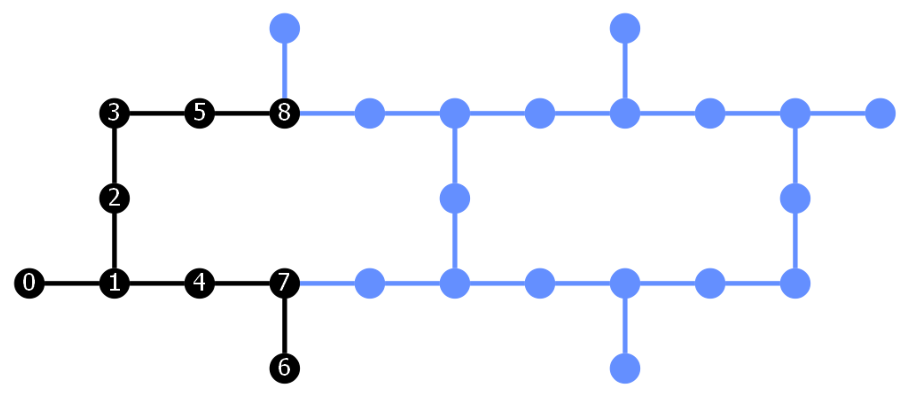

In [39]:
from qiskit_ibm_runtime.fake_provider import FakeAuckland
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.visualization import plot_circuit_layout
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt

backend = FakeAuckland()

pm = generate_preset_pass_manager(
    optimization_level=0,
    backend=backend,
    layout_method='trivial',
    # layout_method='sabre',
    # layout_method='dense',
)

ghz = QuantumCircuit(9)

ghz.h(0)

for i in range(8):
    ghz.cx(i,i+1)

ghz_pm = pm.run(ghz)

plot_circuit_layout(ghz_pm, backend)

위의 코드(plot_circuit_layout)를 실행하기 위해서는, [Graphviz](https://graphviz.org/download/)설치가 필요합니다. 설치 후 visual studio code를 재시작해야합니다.

In [ ]:
pm.run(ghz).depth()

31

Text(0.5, 0, 'Depth')

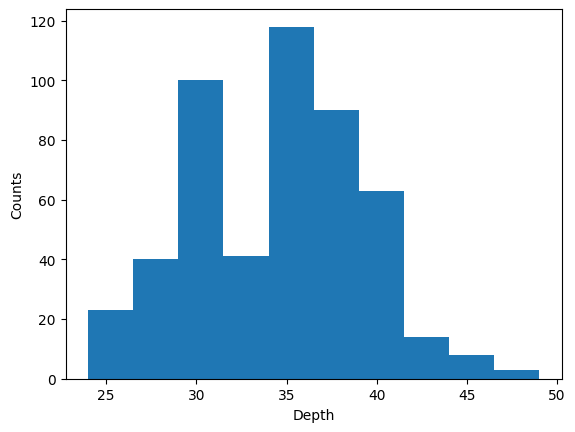

In [41]:
depths = []
for _ in range(500):
    depths.append(pm.run(ghz).depth())

plt.hist(depths)
plt.ylabel("Counts")
plt.xlabel("Depth")

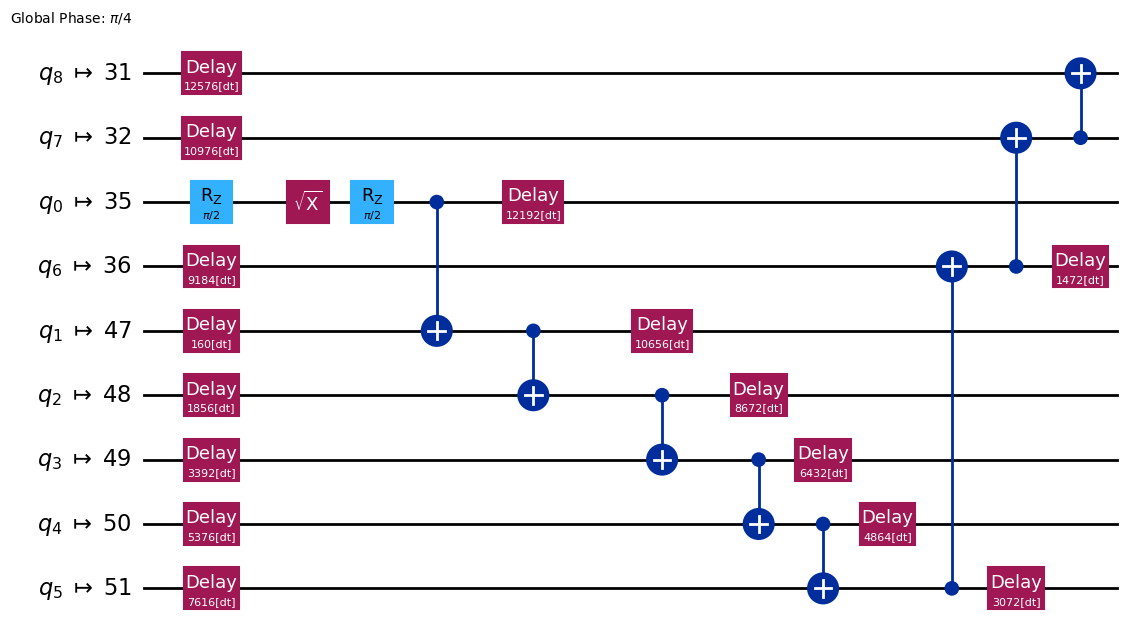

In [78]:
from qiskit_ibm_runtime.fake_provider import FakeWashingtonV2

backend = FakeWashingtonV2()

pm_idle = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    scheduling_method='asap'
    # scheduling_method='alap'
)

ghz_idle = pm_idle.run(ghz)
ghz_idle.draw(output='mpl', idle_wires=False, )

### 5.1 Optimization

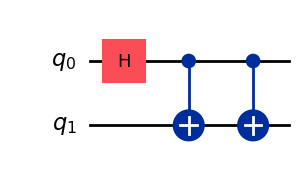

In [92]:
qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1)
qc.cx(0, 1)

qc.draw('mpl')

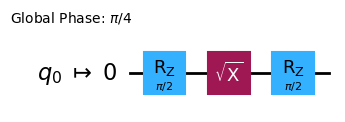

In [98]:
pm= generate_preset_pass_manager(
    # optimization_level=0,
    optimization_level=1,
    backend=backend,
)

qc_pm = pm.run(qc)

qc_pm.draw('mpl')

### 5.3 Error Mitigation (Resilience Level)

    - Sampler & Estimator

        Sampler : 회로 실행 분포
        Estimator : Observable의 기댓값

| Resilience Level | Definition                                                                 | Technique                                               |
|------------------|-----------------------------------------------------------------------------|---------------------------------------------------------|
| 0                | No mitigation                                                              | None                                                    |
| 1 [Default]      | Minimal mitigation costs: Mitigate error associated with readout errors     | Twirled Readout Error eXtinction (TREX), measurement twirling |
| 2                | Medium mitigation costs. Typically reduces bias in estimators, but is not guaranteed to be zero-bias. | Level 1 + Zero Noise Extrapolation (ZNE) and gate twirling |


#### Ising Model 비교

$$
H = Z \otimes Z \\
H \bra
$$

In [105]:
from qiskit.quantum_info import SparsePauliOp

H = SparsePauliOp.from_list([("ZZ", 1.0)])

H

SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j])

In [121]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator

estimator = Estimator(backend)

In [122]:
# 00 상태:
qc = QuantumCircuit(2)

job = estimator.run([(qc, H)])
result = job.result()[0]

print(result.data.evs)


0.9609375


In [128]:
pm = generate_preset_pass_manager(backend=backend,
                                  optimization_level=3,
                                  )
qc_pm = pm.run(qc)
H_pm = H.apply_layout(qc_pm.layout)

job = estimator.run([(qc_pm, H_pm)])
result = job.result()[0]

print(result.data.evs)


0.95751953125


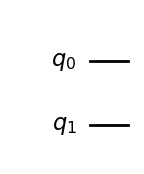

In [130]:
qc.draw('mpl')